<a href="https://colab.research.google.com/github/yashyenugu/Neural-Style-Transfer/blob/edit/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:50px;">Importing Tensorflow and VGG19</h1>

In [1]:
import numpy as np
import tensorflow as tf

In [2]:
print(tf.__version__)

2.3.0


The structure of the VGG19 model can be seen below

In [3]:
model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
model.trainable = False
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [4]:
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array #helper functions to upload and process images
from tensorflow.python.keras.applications.vgg19 import preprocess_input
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import backend as K
 
import matplotlib.pyplot as plt
%matplotlib inline

<h1 style="font-size:50px;">Image Preprocessing</h1>

Once uploaded the function below preprocesses the images for the network. <br>
The input shape for the network needs to be (1,1000,1000,3)

In [5]:
def load_and_process_img(image_path):
  img = load_img(image_path,target_size=(1000,1000))
  img = img_to_array(img)
  img = preprocess_input(img)
  img = np.expand_dims(img,axis = 0) #An extra dimension is added to reshape from (1000,1000,3) to (1,1000,1000,3)
  return img

In case we want to reverse the preprocessing steps of the input, it needs to be done manually. <br>
Unfortunately Tensorflow has no function to do this.

In [6]:
def deprocess(x):
    # perform the inverse of the preprocessiing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
 
    x = np.clip(x, 0, 255).astype('uint8')
    return x
 
def display_image(image):
    if len(image.shape) == 4:
        img = np.squeeze(image, axis = 0) #extra dimension is removed
 
    img = deprocess(img)
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

<h1 style="font-size:50px;">Uploading Content and Style Images</h1>

Upload the images on which you would like to implement Neural Style transfer

In [31]:
from google.colab import files
files.upload()
from IPython.display import clear_output
clear_output()

Rename content_image_name and style_image_name to the names of your images

In [10]:
content_image_name = 'content.jpeg'
style_image_name = 'style.jpg'
content_path = '/content/' + content_image_name
style_path = '/content/' + style_image_name

In [11]:
content = load_and_process_img(content_path)
style = load_and_process_img(style_path)

Run the subsequent cells to check your images.<br>
The images are automatically reshaped to 1000 by 1000 pixels

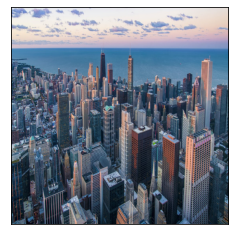

In [12]:
plt.figure()
display_image(content)

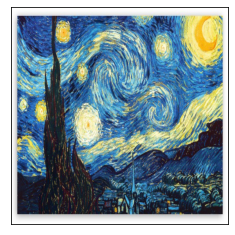

In [13]:
display_image(style)

<h1 style="font-size:50px;">Defining the activation layers for Content and Style images</h1>

The layers listed below are used to compute the activations for the content and style images respectively


In [18]:
style_layers = [
                'block1_conv1',
                'block3_conv1',
                'block5_conv1'
] #Each layer inside this list can be given a weightage of how much they contribute in the forward propagation
 
content_layer = 'block5_conv1'

In [19]:
#Defining the input and output for the model
content_model = Model(inputs = model.input, outputs = model.get_layer(content_layer).output) 
style_models = [Model(inputs = model.input,outputs = model.get_layer(layer).output) for layer in style_layers]

<h1 style="font-size:50px;">Visualizing activations from VGG19</h1>

Running the cells below will show you the activation of the CNN layer using the content and style images

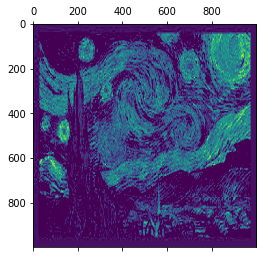

In [16]:
#feel free to change the index to view the activations of 'block1_conv1','block3_conv1' and 'block5_conv1'
index = 0
a_S = style_models[index](style)
plt.matshow(a_S[0,:,:,12])

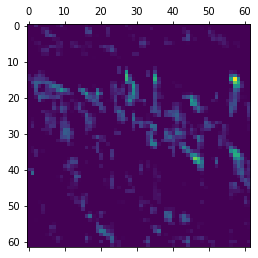

In [22]:
a_C = content_model(content)
plt.matshow(a_C[0,:,:,6])

Note - If the activations aren't highlighting the features you desire to transfer, feel free to change the layer names in the list 'style_layer' and 'content_layer'

<h1 style="font-size:50px;">Defining The Loss Functions</h1>

In [23]:
def content_cost(content,generated): #This function is used to compute cost of content image with respect to the generated image
  a_C = content_model(content)
  a_G = content_model(generated)
  cost =  tf.reduce_mean(tf.square(a_C-a_G))
  return cost
 

In [24]:
def gram_matrix(A): #Defining the gram matrix to be used in computing style cost
  channels = int(A.shape[-1])
  a = tf.reshape(A,[-1,channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a,a,transpose_a = True)
  return gram/tf.cast(n,tf.float32)

In [25]:
lam = 1/len(style_models)   #This function is used to compute cost of style image with respect to the generated image
def style_cost(style,generated):
  J_style = 0
  current_cost = []
  for style_model in style_models:
    a_S = style_model(style)
    a_G = style_model(generated)
    G_s = gram_matrix(a_S)
    G_g = gram_matrix(a_G)
    current_cost.append(tf.reduce_mean(tf.square(G_s-G_g)))
  J_style = (4/6)*current_cost[0] + (1/6)*current_cost[1] + (1/6)*current_cost[2]

  #The layers defined in the list style_layers are given weightages (4/6),(1/6) and (1/6) respectively.
  #The weightages vary from image to image and the patterns you want to implement from the style image
 
  return J_style
 
#print(style_cost(content,style))

<h1 style="font-size:50px;">Defining Training Loop</h1>



The training loop uses tf.GradientTape to compute the derivative of the content and style cost with respect to the generated image

In [26]:
generated_images = []
def training_loop(content_path,style_path,iterations,alpha,beta,lr_rate):
  content = load_and_process_img(content_path)
  style = load_and_process_img(style_path)
  generated = tf.Variable(content)
  min_costs = []
  
 
  opt = tf.optimizers.Adam(learning_rate = lr_rate)
  J_min = 1e12 + 0.1
  for i in range(iterations+1):
    
    with tf.GradientTape() as tape: #Defining tf.GradientTape
      J_content = content_cost(content,generated)
      J_style = style_cost(style,generated)
      J_cost = alpha*J_content + beta*J_style
    
    grads = tape.gradient(J_cost,generated)
    opt.apply_gradients([(grads,generated)])
    if J_cost<J_min:
      J_min = J_cost #picks the generated image with the lowest J_cost
      best_pic = generated.numpy()
    if i%2 == 0:
      print('cost at iteration '+str(i)+' = '+ str(J_cost.numpy()))
      generated_images.append(generated.numpy())
  
  return best_pic

<h1 style="font-size:50px;">Training</h1>



Run the cell to execute the loop

The hyperaparameters are listed below.<br>
Note that these hyperparameters vary from image to image. They need to be tuned accordingly

In [27]:
itr = 180
alpha = 10
beta = 80
lr = 8
final = training_loop(content_path,style_path,itr,alpha,beta,lr)

cost at iteration 0 = 87343370000.0
cost at iteration 2 = 27706896000.0
cost at iteration 4 = 9519096000.0
cost at iteration 6 = 5370948000.0
cost at iteration 8 = 4593998000.0
cost at iteration 10 = 3121484000.0
cost at iteration 12 = 2344806000.0
cost at iteration 14 = 1982650400.0
cost at iteration 16 = 1648370800.0
cost at iteration 18 = 1356054500.0
cost at iteration 20 = 1146277400.0
cost at iteration 22 = 994586700.0
cost at iteration 24 = 875146300.0
cost at iteration 26 = 767685500.0
cost at iteration 28 = 684420100.0
cost at iteration 30 = 616820860.0
cost at iteration 32 = 556870700.0
cost at iteration 34 = 503586880.0
cost at iteration 36 = 458838240.0
cost at iteration 38 = 419754430.0
cost at iteration 40 = 386981400.0
cost at iteration 42 = 358060860.0
cost at iteration 44 = 332035600.0
cost at iteration 46 = 310237570.0
cost at iteration 48 = 290315550.0
cost at iteration 50 = 273743330.0
cost at iteration 52 = 257893730.0
cost at iteration 54 = 243901870.0
cost at iter

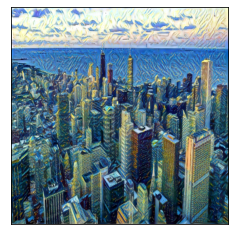

In [28]:
display_image(final) #view the result of the training loop (generated image)

Note that the image shown above will not show the patterns obtained due to it's small size. Run the above cell just to verify if the network is going in the direction.

<h1 style="font-size:50px;">Saving the generated image</h1>



Run the following cells to save your generated image

In [29]:
result = np.squeeze(generated_images[-1], axis = 0) #reduce the extra dimension
result = deprocess(result)
result = tf.keras.preprocessing.image.array_to_img(result)
result = result.save('result.jpg')


View the image *result.jpg* to see the finer details 